# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1

In this notebook, we will implement a computer vision system for product identification using template matching. Template matching is a technique used to locate instances of a template image (or pattern) within a larger image. Our goal is to develop a system that can accurately detect instances of products in store shelves from scene images, using reference images provided for each product.

Importing data from Google Drive folder.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Mounted at /content/drive
Archive:  dataset.zip
   creating: dataset/
  inflating: __MACOSX/._dataset      
   creating: dataset/scenes/
  inflating: __MACOSX/dataset/._scenes  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/models/
  inflating: __MACOSX/dataset/._models  
  inflating: dataset/scenes/scene12.png  
  inflating: __MACOSX/dataset/scenes/._scene12.png  
  inflating: dataset/scenes/scene10.png  
  inflating: __MACOSX/dataset/scenes/._scene10.png  
  inflating: dataset/scenes/scene11.png  
  inflating: __MACOSX/dataset/scenes/._scene11.png  
  inflating: dataset/scenes/scene5.png  
  inflating: __MACOSX/dataset/scenes/._scene5.png  
  inflating: dataset/scenes/scene4.png  
  inflating: __MACOSX/dataset/scenes/._scene4.png  
  inflating: dataset/scenes/scene6.png  
  inflating: __MACOSX/dataset/scenes/._scene6.png  
  inflating: dataset/scenes/scene7.png  
  inflating: __MACOSX/dataset/scenes/._scene7.png  
  inflating: 

As usual, let's start by importing the necessary Python libraries for our project:

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

Before we begin, we need to visualize an example scene image to understand the type of noise present and its effect on the image quality. There are several types of noise that can corrupt an image, including Gaussian noise, salt-and-pepper noise, and speckle noise.


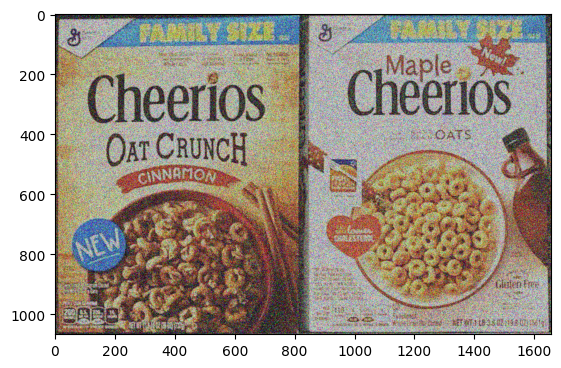

In [4]:
image = cv2.imread('dataset/scenes/scene1.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.show()

Zooming into a homogeneous area allows us to closely examine the image details.

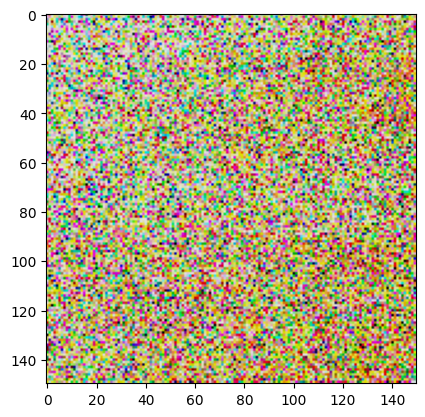

In [125]:
flat_region = image_rgb[400:550, 650:800]

plt.imshow(flat_region)
plt.show()

We visualize the histogram of the flat region.

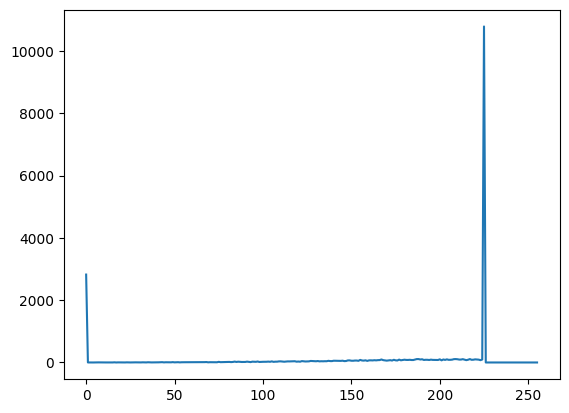

In [126]:
histr = cv2.calcHist([flat_region],[0],None,[256],[0,256])
plt.plot(histr)
plt.show()

We apply the median filter to remove impulse noise, such as salt-and-pepper noise, which can distort the appearance of objects in the image.

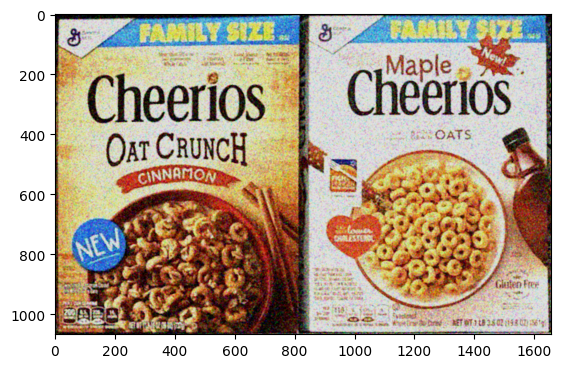

In [6]:
filtered_image = cv2.medianBlur(image_rgb, 5)

plt.imshow(filtered_image)
plt.show()

Wavelet denoising is a powerful technique for reducing noise in images while preserving important features and details. The VisuShrink method is a popular wavelet thresholding technique that removes noise by shrinking the wavelet coefficients below a certain threshold. This helps enhance the signal-to-noise ratio and improve the overall quality of the image, making it more suitable for accurate template matching.


In [7]:
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage import data, img_as_float

image_float = img_as_float(filtered_image)

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(image_float, channel_axis=-1, average_sigmas=True)
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

Estimated Gaussian noise standard deviation = 0.01857601059491276


It converts the image to the YCbCr color space for denoising, uses the VisuShrink method with soft thresholding, and scales the denoising parameter sigma by a factor of 1/4 of the estimated.

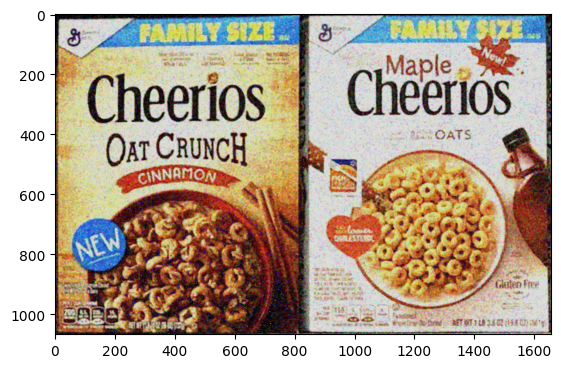

In [8]:
denoised_image = denoise_wavelet(
    image_float,
    channel_axis=-1,
    convert2ycbcr=True,
    method='VisuShrink',
    mode='soft',
    sigma=sigma_est / 4,
    rescale_sigma=True,
)

# Convert to uint8 and scale to [0, 255] range
denoised_image = (denoised_image * 255).astype(np.uint8)

plt.imshow(denoised_image)
plt.show()

In [119]:
def wavelter_filter(image):
  image_float = img_as_float(image)
  sigma_est = estimate_sigma(image_float, channel_axis=-1, average_sigmas=True)

  denoised_image = denoise_wavelet(
    image_float,
    channel_axis=-1,
    convert2ycbcr=True,
    method='VisuShrink',
    mode='soft',
    sigma=sigma_est / 4,
    rescale_sigma=True,
    )

  denoised_image = (denoised_image * 255).astype(np.uint8)
  return denoised_image

# Track A - Single Instance Detection

In this section, we'll focus on detecting a single instance of each product in the scene images. We'll iterate over each scene image and reference image pair and apply the template matching algorithm to detect instances of products.







We'll start by loading the reference images for Track A, which includes {ref1.png to ref14.png}. These images represent one reference image for each product that the system should be able to identify.

In [120]:
ref_images = {}
ref_paths = [f"dataset/models/ref{i+1}.png" for i in range(14)]

for ref_path in ref_paths:
  name, _ = os.path.splitext(os.path.basename(ref_path))
  ref_img = cv2.imread(ref_path)
  ref_images[name] = ref_img

Next, we'll load the scene images for Track A, which includes {scene1.png to scene5.png}. These images represent different shelf pictures to test the developed algorithm in different scenarios.

In [121]:
scene_images = {}
scene_paths = [f"dataset/scenes/scene{i+1}.png" for i in range(5)]

for scene_path in scene_paths:
  name, _ = os.path.splitext(os.path.basename(scene_path))
  scene_img = cv2.imread(scene_path)
  scene_images[name] = scene_img

First, we create a new directory to store the denoised scenes.


In [122]:
directory = "scenes_filtered"
if not os.path.exists(directory):
    os.makedirs(directory)

We apply denoising techniques to the scene images using the filters studied earlier.

In [123]:
preprocessed_scenes = {}

for scene_name, scene_img in scene_images.items():
  filtered_img = cv2.medianBlur(scene_img, 5)
  smoothed_img = wavelter_filter(filtered_img)
  preprocessed_scenes[scene_name] = smoothed_img
  # scene_img = cv2.edgePreservingFilter(denoised, flags=cv2.RECURS_FILTER)
  cv2.imwrite(os.path.join(directory, scene_name + '.png'), smoothed_img)

# Template Matching Algorithm

## Overview

Template matching involves sliding a template image over a larger image and computing a similarity score at each position. The position with the highest similarity score indicates the location of the template within the larger image.

## Steps

1. Load the reference image and scene image.
2. Convert both images to grayscale for simplicity.
3. Choose a template matching method (e.g., correlation coefficient, squared difference).
4. Apply template matching to find instances of the template in the scene.
5. Post-process the results (e.g., thresholding, non-maximum suppression) to refine the detections.

In [146]:
import imutils
from imutils.object_detection import non_max_suppression

def template_matching(scene_img, model_img, th = 0.7, overlap_th = 0.3):
  gray_scene = cv2.cvtColor(scene_img, cv2.COLOR_BGR2GRAY)
  gray_model = cv2.cvtColor(model_img, cv2.COLOR_BGR2GRAY)

  # Initialize list to store bounding boxes
  bounding_boxes = []
  rects = []

  w_img, h_img = gray_scene.shape[::-1]
  for scale in np.linspace(0.2, 1.0, 50):
    resized = imutils.resize(gray_model, width = int(gray_model.shape[1] * scale))
    r = gray_model.shape[1] / float(resized.shape[1])

    if resized.shape[0] > h_img or resized.shape[1] > w_img:
      break

    res = cv2.matchTemplate(gray_scene, resized, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= th)

    for pt in zip(*loc[::-1]):
      rects.append((pt[0], pt[1], pt[0] + resized.shape[1], pt[1] + resized.shape[0]))

  pick = non_max_suppression(np.array(rects), overlapThresh = overlap_th)

  for (startX, startY, endX, endY) in pick:
    w, h = (abs(startX - endX), abs(startY - endY))
    x_center = startX + w // 2
    y_center = startY + h // 2

    bounding_boxes.append({
        "position": (x_center, y_center),
        "width": w,
        "height": h
        })

  return bounding_boxes

We apply the algoritgm above for all the scenes:

Processing scene1
Product ref1 - 1 instance(s) found:
Instance 1: position: (421, 541), width: 806px, height: 1053px
Product ref2 - 1 instance(s) found:
Instance 1: position: (1250, 541), width: 806px, height: 1053px




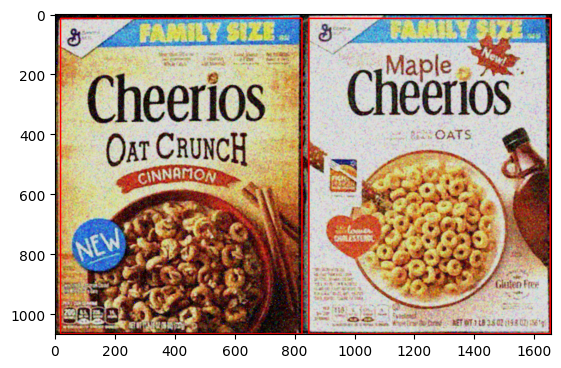

Processing scene2
Product ref3 - 1 instance(s) found:
Instance 1: position: (312, 496), width: 606px, height: 944px
Product ref4 - 1 instance(s) found:
Instance 1: position: (933, 484), width: 645px, height: 968px
Product ref5 - 1 instance(s) found:
Instance 1: position: (1530, 457), width: 572px, height: 860px




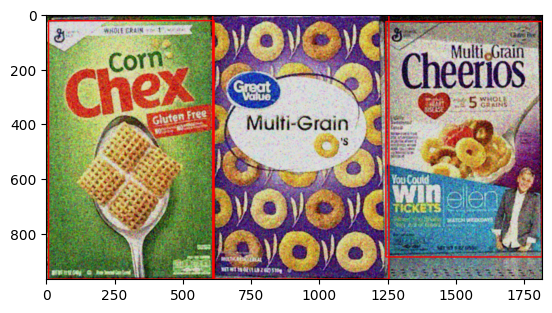

Processing scene3
Product ref6 - 1 instance(s) found:
Instance 1: position: (312, 459), width: 593px, height: 662px
Product ref7 - 1 instance(s) found:
Instance 1: position: (897, 462), width: 548px, height: 656px
Product ref8 - 1 instance(s) found:
Instance 1: position: (1457, 395), width: 567px, height: 790px




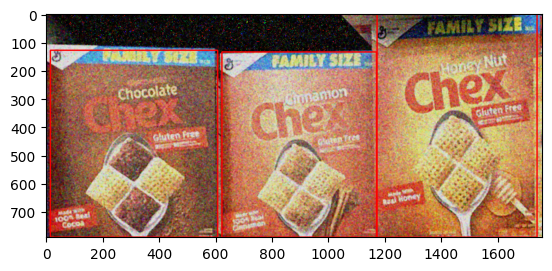

Processing scene4
Product ref1 - 1 instance(s) found:
Instance 1: position: (888, 916), width: 391px, height: 510px
Product ref8 - 1 instance(s) found:
Instance 1: position: (351, 264), width: 363px, height: 506px
Product ref9 - 1 instance(s) found:
Instance 1: position: (175, 944), width: 321px, height: 456px
Product ref10 - 1 instance(s) found:
Instance 1: position: (938, 295), width: 261px, height: 392px




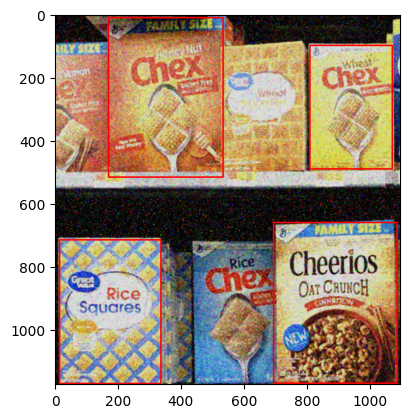

Processing scene5
Product ref11 - 1 instance(s) found:
Instance 1: position: (369, 758), width: 373px, height: 562px
Product ref12 - 1 instance(s) found:
Instance 1: position: (713, 742), width: 432px, height: 642px




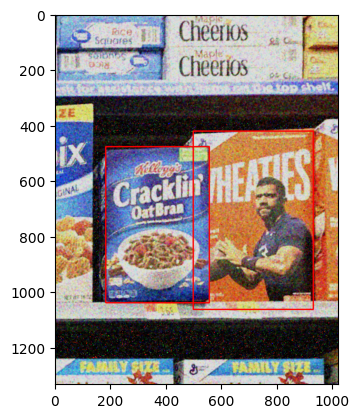

In [124]:
def generate_output(results, scene_img, show_bounding_boxes=False):
  for product_id, result in results.items():
    print("Product", product_id, "-", result["instances_found"], "instance(s) found:")
    for i, bbox in enumerate(result["bounding_boxes"], 1):
      print(f"Instance {i}: position: {bbox['position']}, width: {bbox['width']}px, height: {bbox['height']}px")
      if show_bounding_boxes:
        pt = bbox['position']
        w = bbox['width']
        h = bbox['height']

        tl = (int(pt[0] - w / 2), int(pt[1] - h / 2))
        br = (int(pt[0] + w / 2), int(pt[1] + h / 2))
        cv2.rectangle(scene_img, tl, br, (0, 0, 255), 3)
  print("\n")

  if show_bounding_boxes:
    plt.imshow(cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB))
    plt.show()

##########################################################

for scene_name, scene_img in preprocessed_scenes.items():
  print(f"Processing {scene_name}")
  results = {}

  for ref_name, ref_img  in ref_images.items():
    bounding_boxes = template_matching(scene_img, ref_img)

    if bounding_boxes:
      product_id = os.path.splitext(ref_name)[0]
      results[product_id] = {
          "instances_found": len(bounding_boxes),
          "bounding_boxes": bounding_boxes
      }
  generate_output(results, scene_img, show_bounding_boxes = True)

# Track B - Multiple Instances Detection

Building upon the previous section, we'll enhance our system to detect multiple instances of the same product within a scene image. We'll iterate over each scene image and reference image pair and extend the template matching algorithm to handle multiple detections.

We load the reference images for Track B, which includes {ref15.png to ref27.png}. These additional images will expand the range of products that the system can identify.

In [133]:
ref_images = {}
ref_paths = [f"dataset/models/ref{i+15}.png" for i in range(13)]

for ref_path in ref_paths:
  name, _ = os.path.splitext(os.path.basename(ref_path))
  ref_img = cv2.imread(ref_path)
  ref_images[name] = ref_img

Finally, we'll load the scene images for Track B, which includes {scene6.png to scene12.png}. These images provide further test cases for detecting multiple instances of the same product within a scene.

In [134]:
scene_images = {}
scene_paths = [f"dataset/scenes/scene{i+6}.png" for i in range(7)]

for scene_path in scene_paths:
  name, _ = os.path.splitext(os.path.basename(scene_path))
  scene_img = cv2.imread(scene_path)
  scene_images[name] = scene_img

First, we create a new directory to store the denoised scenes.

In [135]:
directory = "scenes_filtered"
if not os.path.exists(directory):
    os.makedirs(directory)

We apply denoising techniques to the scene images using the filters studied earlier.

In [165]:
preprocessed_scenes = {}

for scene_name, scene_img in scene_images.items():
  filtered_img = cv2.medianBlur(scene_img, 5)
  smoothed_img = wavelter_filter(filtered_img)
  # smoothed_img = cv2.edgePreservingFilter(smoothed_img, flags=cv2.RECURS_FILTER)
  preprocessed_scenes[scene_name] = smoothed_img
  cv2.imwrite(os.path.join(directory, scene_name + '.png'), smoothed_img)

We apply the algoritgm above for all the scenes:

Processing scene6
Product ref15 - 3 instance(s) found:
Instance 1: position: (938, 619), width: 326px, height: 906px
Instance 2: position: (564, 627), width: 320px, height: 889px
Instance 3: position: (189, 627), width: 320px, height: 889px




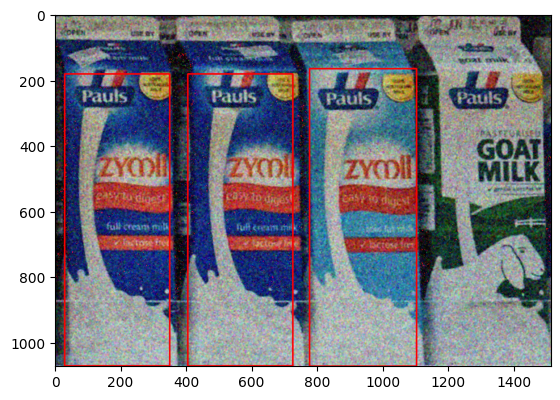

Processing scene7
Product ref16 - 2 instance(s) found:
Instance 1: position: (1033, 458), width: 222px, height: 615px
Instance 2: position: (799, 468), width: 215px, height: 595px




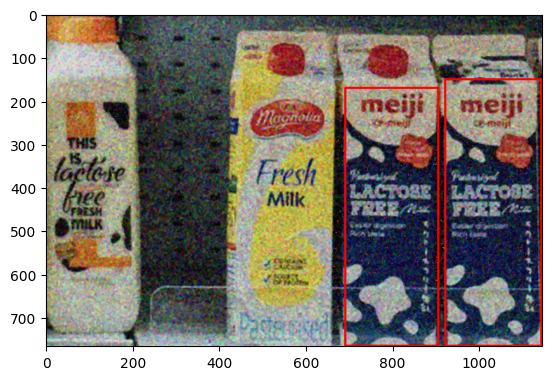

Processing scene8
Product ref17 - 3 instance(s) found:
Instance 1: position: (1341, 581), width: 326px, height: 854px
Instance 2: position: (992, 580), width: 326px, height: 854px
Instance 3: position: (648, 576), width: 326px, height: 854px
Product ref23 - 3 instance(s) found:
Instance 1: position: (1339, 575), width: 326px, height: 878px
Instance 2: position: (988, 575), width: 326px, height: 878px
Instance 3: position: (645, 567), width: 326px, height: 878px
Product ref24 - 3 instance(s) found:
Instance 1: position: (1338, 584), width: 331px, height: 859px
Instance 2: position: (989, 584), width: 331px, height: 859px
Instance 3: position: (645, 578), width: 331px, height: 859px




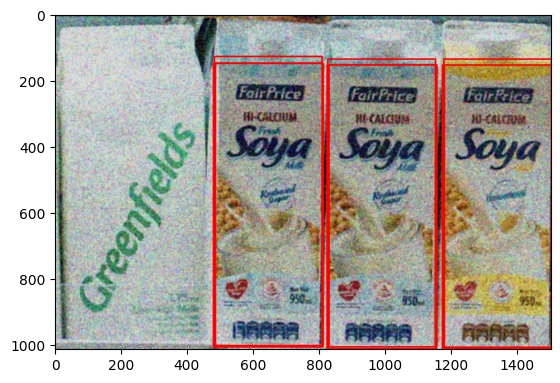

Processing scene9
Product ref19 - 2 instance(s) found:
Instance 1: position: (852, 382), width: 226px, height: 560px
Instance 2: position: (619, 379), width: 226px, height: 560px
Product ref20 - 1 instance(s) found:
Instance 1: position: (1362, 381), width: 232px, height: 560px




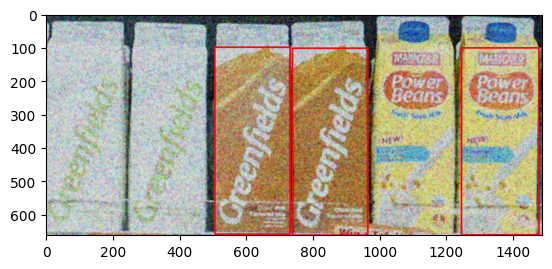

Processing scene10
Product ref21 - 2 instance(s) found:
Instance 1: position: (711, 545), width: 256px, height: 721px
Instance 2: position: (983, 544), width: 249px, height: 702px
Product ref22 - 4 instance(s) found:
Instance 1: position: (1263, 547), width: 256px, height: 721px
Instance 2: position: (983, 544), width: 256px, height: 721px
Instance 3: position: (1526, 540), width: 249px, height: 702px
Instance 4: position: (710, 534), width: 249px, height: 702px




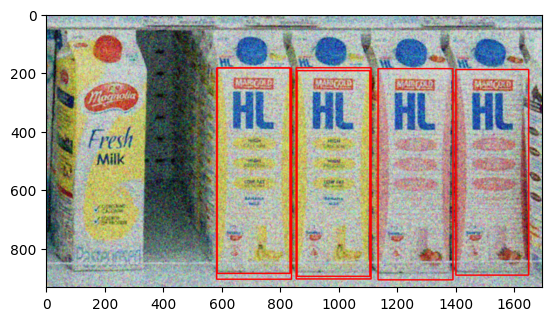

Processing scene11
Product ref17 - 3 instance(s) found:
Instance 1: position: (556, 369), width: 187px, height: 489px
Instance 2: position: (359, 369), width: 187px, height: 489px
Instance 3: position: (164, 366), width: 187px, height: 489px
Product ref23 - 3 instance(s) found:
Instance 1: position: (556, 365), width: 184px, height: 496px
Instance 2: position: (359, 365), width: 184px, height: 496px
Instance 3: position: (164, 361), width: 184px, height: 496px
Product ref24 - 4 instance(s) found:
Instance 1: position: (555, 372), width: 187px, height: 485px
Instance 2: position: (356, 371), width: 187px, height: 485px
Instance 3: position: (744, 371), width: 187px, height: 485px
Instance 4: position: (164, 367), width: 187px, height: 485px
Product ref25 - 3 instance(s) found:
Instance 1: position: (1342, 384), width: 193px, height: 501px
Instance 2: position: (1143, 381), width: 193px, height: 501px
Instance 3: position: (942, 379), width: 193px, height: 501px




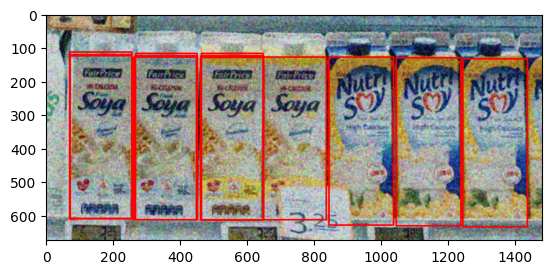

Processing scene12
Product ref26 - 2 instance(s) found:
Instance 1: position: (410, 399), width: 234px, height: 595px
Instance 2: position: (140, 388), width: 234px, height: 595px
Product ref27 - 1 instance(s) found:
Instance 1: position: (954, 403), width: 257px, height: 596px




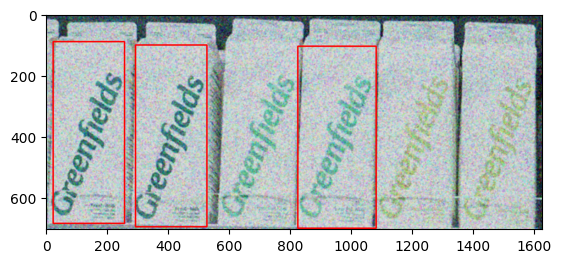

In [117]:
for scene_name, scene_img in preprocessed_scenes.items():
  print(f"Processing {scene_name}")
  results = {}

  for ref_name, ref_img  in ref_images.items():
    bounding_boxes = template_matching(scene_img, ref_img)

    if bounding_boxes:
      product_id = os.path.splitext(ref_name)[0]
      results[product_id] = {
          "instances_found": len(bounding_boxes),
          "bounding_boxes": bounding_boxes
      }
  generate_output(results, scene_img, show_bounding_boxes = True)

WIP: enhancing multiple instance detection by adding a new reference when a true match is found

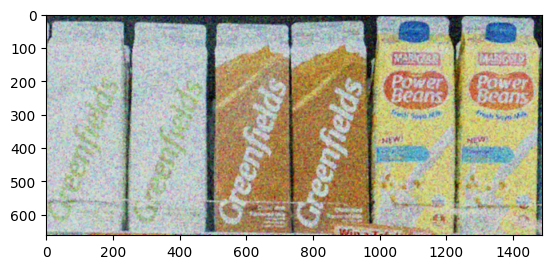

In [178]:
clone = preprocessed_scenes['scene9'].copy()
bounding_boxes = template_matching(clone, ref_images['ref21'])

for bbox in bounding_boxes:
        # Extract position, width, and height
        x_center, y_center = bbox["position"]
        w, h = bbox["width"], bbox["height"]

        # Calculate top-left and bottom-right coordinates of the rectangle
        x1 = int(x_center - w / 2)
        y1 = int(y_center - h / 2)
        x2 = int(x_center + w / 2)
        y2 = int(y_center + h / 2)

        # Draw rectangle on the image
        cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.show()